Saving page_1.png to page_1.png


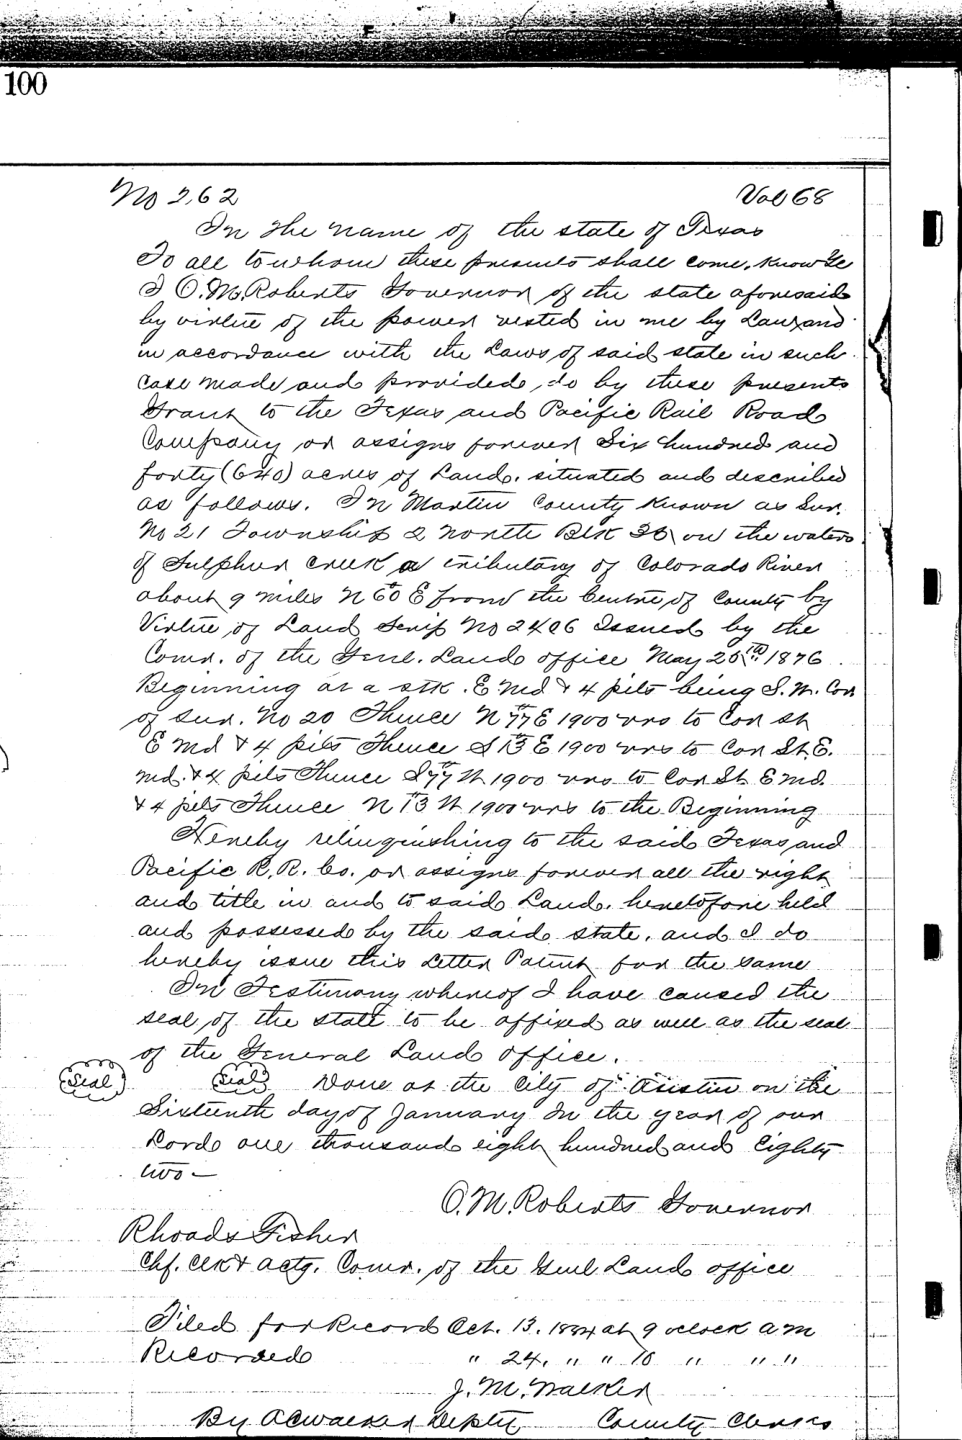

In [2]:
from google.colab import files
import cv2
from google.colab.patches import cv2_imshow

# Upload an image
uploaded = files.upload()

# Get the name of the uploaded file
file_name = list(uploaded.keys())[0]

# Read the uploaded image
img = cv2.imread(file_name)

# Display the image
cv2_imshow(img)

In [3]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2

img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

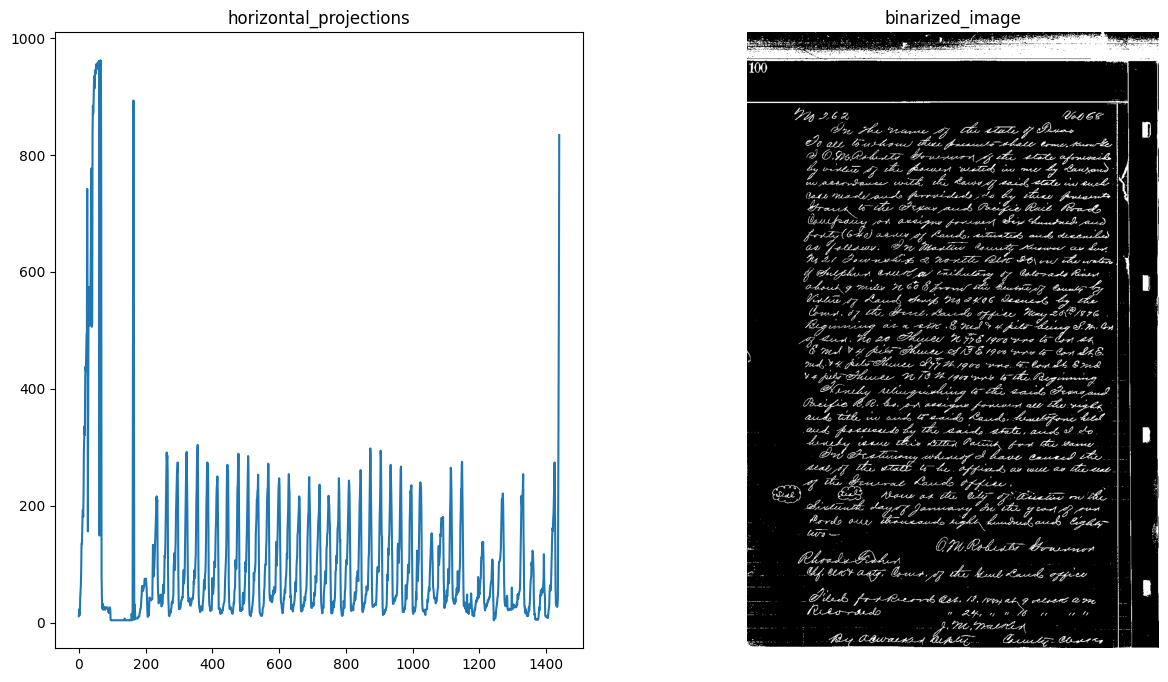

In [4]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)

def binarize_image(image):
    threshold = threshold_otsu(img)
    return image < threshold

binarized_image = binarize_image(img)
hpp = horizontal_projections(binarized_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binarized_image, cmap="gray")

plt.show()

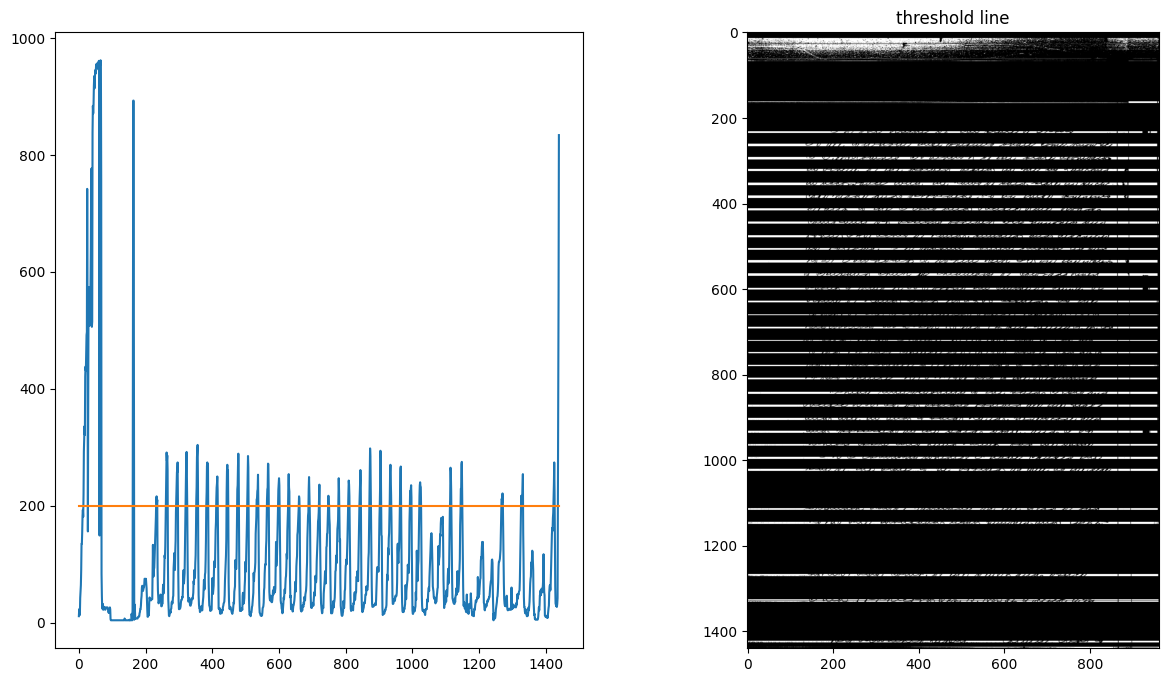

In [5]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2
threshold = 200
peaks = find_peak_regions(hpp, threshold)
peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()

In [6]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 10]
print("peak groups found", len(peak_groups))

peak groups found 35


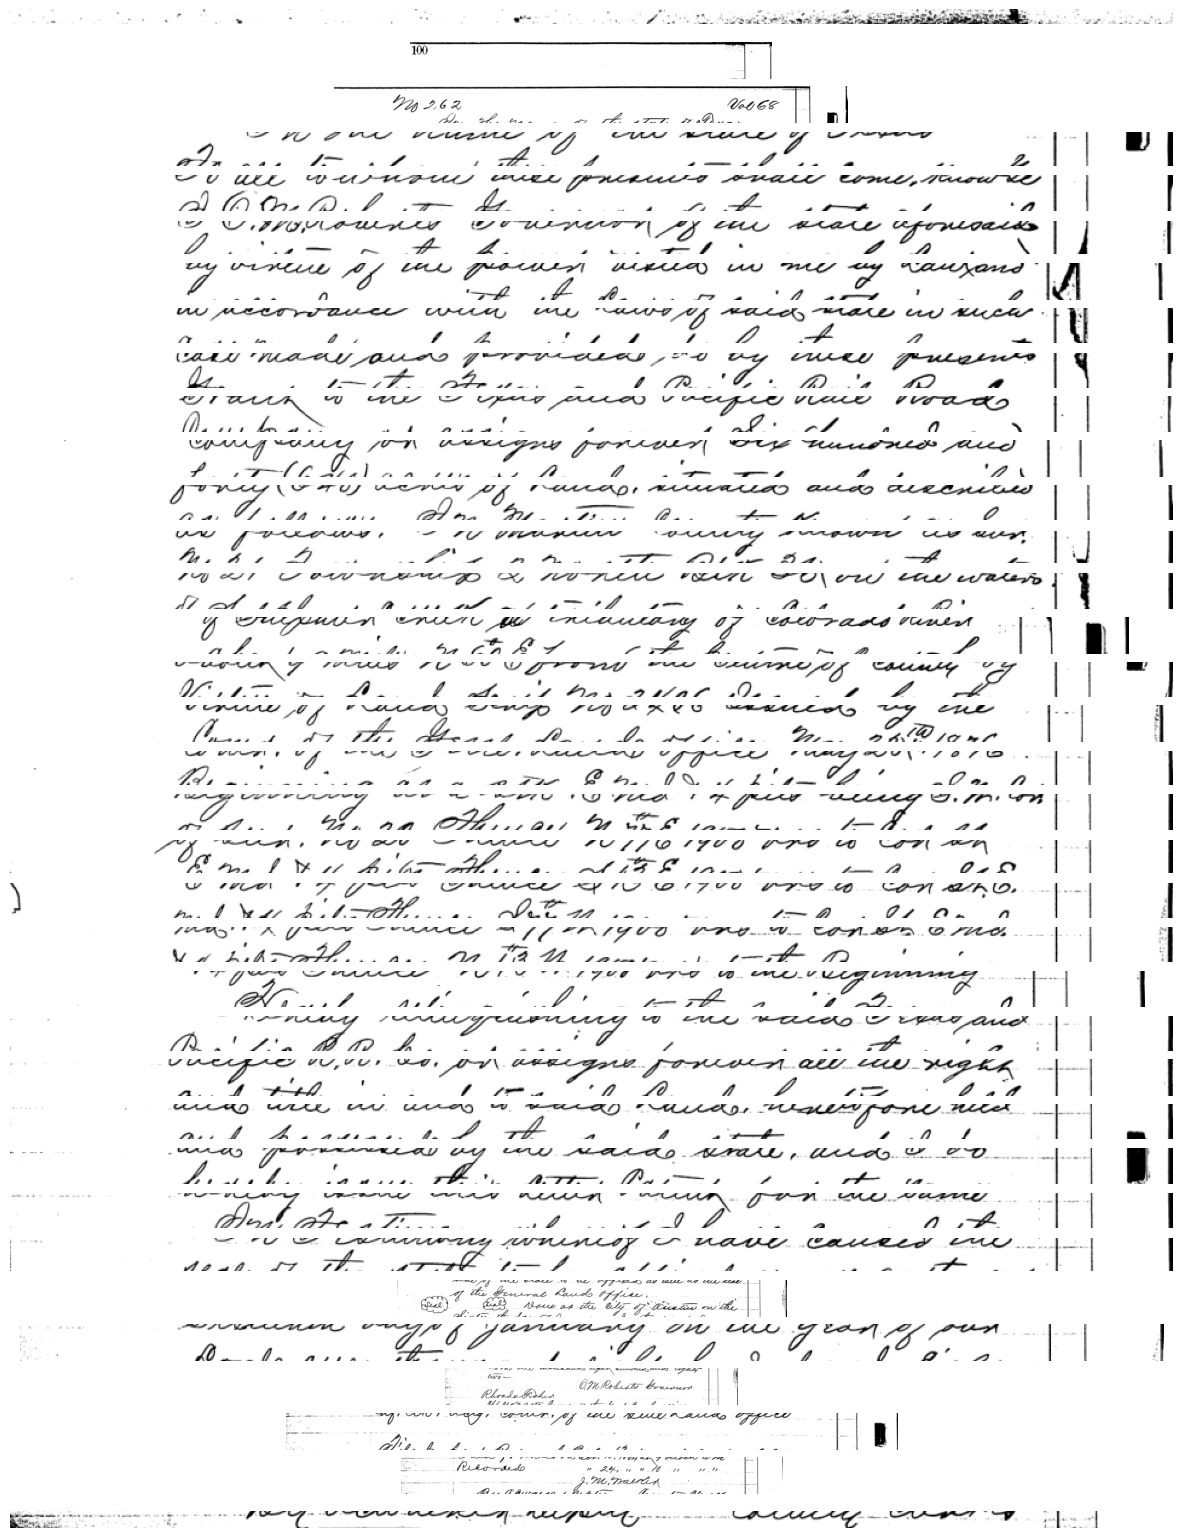

In [7]:
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [8]:
#a star path planning algorithm

from heapq import *
import math

def heuristic(a, b): # euclid distance
    return max(abs(b[0] - a[0]), abs(b[1] - a[1]))

def astar(array, start, goal):
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    while oheap:
        current = heappop(oheap)[1]
#         print('current',current)
        if current == goal:
            data = []
            while current in came_from:
#                 print('currentincamefrom',came_from)
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return []

In [43]:
import numpy as np
from skimage.filters import threshold_otsu
import pdb

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary * 1
    return binary
#     return np.expand_dims(binary, axis=-1)  # Add an additional dimension to make it 2D


# Assuming img is your original image
binary_image = get_binary(img)
segment_separating_lines = []

#Split the binary image into two parts
mid_point = binary_image.shape[1] // 2
left_part = binary_image[:, :mid_point]
right_part = binary_image[:, mid_point:]
try:
  for i, sub_image_index in enumerate(peak_groups):
      nmap = left_part[sub_image_index[0]:sub_image_index[-1]]
      path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
      offset_from_top = sub_image_index[0]
      path[:,0] += offset_from_top
      segment_separating_lines.append(path)
except IndexError as e:
  print(f"First half of the binary image data")

First half of the binary image data


In [44]:
segment_separating_lines_1=[]
try:
  for i, sub_image_index in enumerate(peak_groups):
      nmap = right_part[sub_image_index[0]:sub_image_index[-1]]
      path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
      offset_from_top = sub_image_index[0]
      path[:,0] += offset_from_top
      segment_separating_lines.append(path)
except IndexError as e:
  print(f"Second half of the binary image data")

Second half of the binary image data


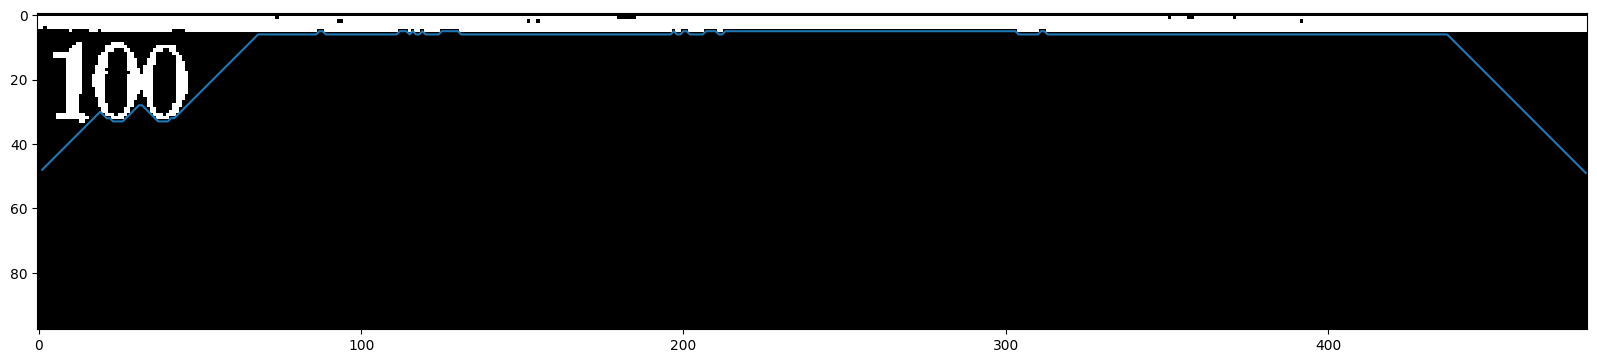

In [45]:
cluster_of_interest = peak_groups[1]
offset_from_top = cluster_of_interest[0]
nmap = left_part[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot(path[:,1], path[:,0])

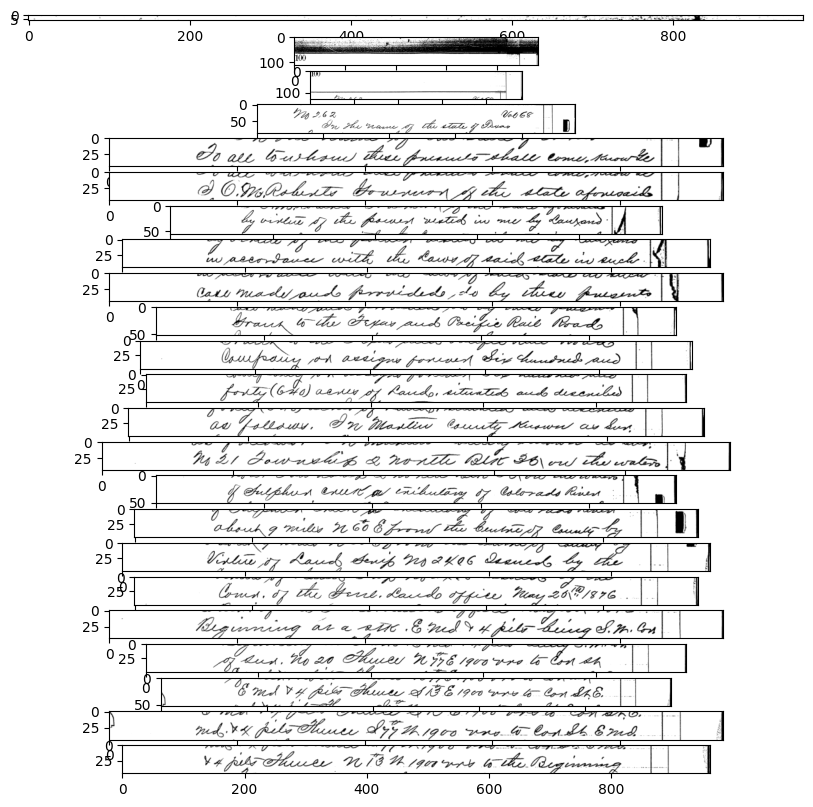

In [47]:
# TODO: the below splitting image algorithm is too simple
# I need to write a cleaner one.
import os
segment_separating_lines_copy = segment_separating_lines.copy()
seperated_images = []

first_line = []
for i in range(len(segment_separating_lines_copy[0])):
    first_line.append([0, i])
segment_separating_lines_copy.insert(0, np.array(first_line))

for index, line_segments in enumerate(segment_separating_lines_copy):
    if index < len(segment_separating_lines_copy)-1:
        lower_line = np.min(segment_separating_lines_copy[index][:,0])
        upper_line = np.max(segment_separating_lines_copy[index+1][:,0])
        seperated_images.append(img[lower_line:upper_line])
        # Specify the output folder path
output_folder_path = '/content/output_folder'
os.makedirs(output_folder_path, exist_ok=True)
# visualize it
fig, ax = plt.subplots(figsize=(10,10), nrows=len(seperated_images))
for index, line_image in enumerate(seperated_images):
    ax[index].imshow(line_image, cmap="gray")
    file_name = f"line_{index + 1}.png"
    file_path = os.path.join(output_folder_path, file_name)
    cv2.imwrite(file_path, line_image)

plt.show()

In [19]:
from google.colab import files
import shutil

# Zip the output folder
shutil.make_archive("/content/output_images", 'zip', "/content/output_folder")

# Trigger the download of the zip file
files.download("/content/output_images.zip")
print(f"Images saved in the folder: {output_folder_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

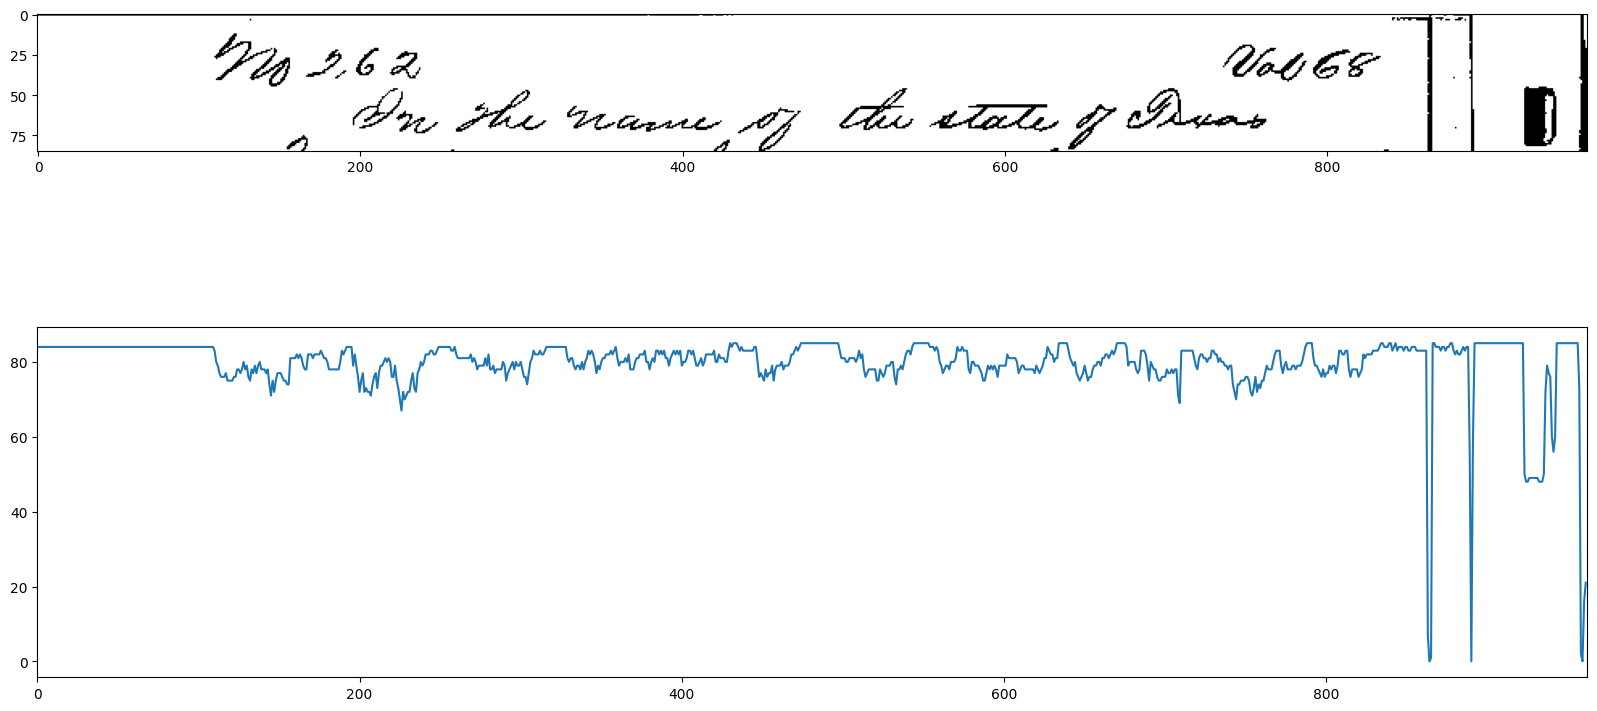

In [48]:
from skimage.filters import threshold_otsu

#binarize the image, guassian blur will remove any noise in the image
first_line = seperated_images[3]
thresh = threshold_otsu(first_line)
binary = first_line > thresh

# find the vertical projection by adding up the values of all pixels along rows
vertical_projection = np.sum(binary, axis=0)

# plot the vertical projects
fig, ax = plt.subplots(nrows=2, figsize=(20,10))
plt.xlim(0, first_line.shape[1])
ax[0].imshow(binary, cmap="gray")
ax[1].plot(vertical_projection)

In [49]:
height = first_line.shape[0]

## we will go through the vertical projections and
## find the sequence of consecutive white spaces in the image
whitespace_lengths = []
whitespace = 0
for vp in vertical_projection:
    if vp == height:
        whitespace = whitespace + 1
    elif vp != height:
        if whitespace != 0:
            whitespace_lengths.append(whitespace)
        whitespace = 0 # reset whitepsace counter.

print("whitespaces:", whitespace_lengths)
avg_white_space_length = np.mean(whitespace_lengths)
print("average whitespace lenght:", avg_white_space_length)

whitespaces: [1, 3, 24, 10, 6, 6, 4, 2, 2, 1, 2, 2, 31, 14]
average whitespace lenght: 7.714285714285714


In [50]:
## find index of whitespaces which are actually long spaces using the avg_white_space_length
whitespace_length = 0
divider_indexes = []
for index, vp in enumerate(vertical_projection):
    if vp == height:
        whitespace_length = whitespace_length + 1
    elif vp != height:
        if whitespace_length != 0 and whitespace_length > avg_white_space_length:
            divider_indexes.append(index-int(whitespace_length/2))
            whitespace_length = 0 # reset it

print(divider_indexes)

[484, 549, 670, 837, 905, 950]


In [51]:
# lets create the block of words from divider_indexes
divider_indexes = np.array(divider_indexes)
dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))
len(dividers)

5

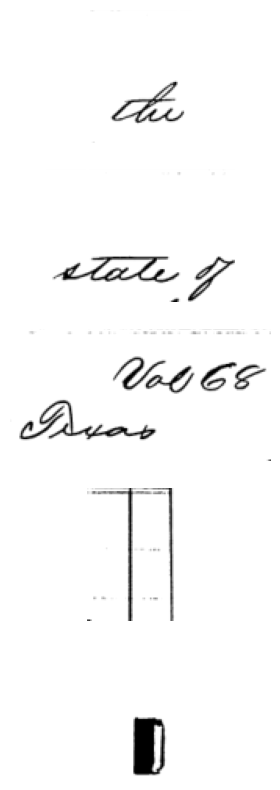

In [52]:
# now plot the findings
fig, ax = plt.subplots(nrows=len(dividers), figsize=(5,10))
if len(dividers) > 1:
    for index, window in enumerate(dividers):
        ax[index].axis("off")
        ax[index].imshow(first_line[:,window[0]:window[1]], cmap="gray")
else:
    ax.axis("off")
    ax.imshow(first_line[:,dividers[0][0]:dividers[0][1]], cmap="gray")